#CHALLENGE PLATINUM

##Library

In [25]:
import pandas as pd
import regex as re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from collections import defaultdict
from keras.models import load_model

##Data Collection

In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/DSC20/train.csv', sep=';', on_bad_lines='skip')

#Data Understanding

##Data Dictionary

In [3]:
df_train.head(10)

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [5]:
df_train.shape

(11000, 2)

In [6]:
df_train.label.value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

#Data Preprocessing

##Text Normalization/Cleansing

In [7]:
def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [8]:
df_train['text_clean'] = df_train.text.apply(cleansing)

In [9]:
df_train.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


In [10]:
neg = df_train.loc[df_train['label'] == 'negative'].text_clean.tolist()
neu = df_train.loc[df_train['label'] == 'neutral'].text_clean.tolist()
pos = df_train.loc[df_train['label'] == 'positive'].text_clean.tolist()

neg_label = df_train.loc[df_train['label'] == 'negative'].label.tolist()
neu_label = df_train.loc[df_train['label'] == 'neutral'].label.tolist()
pos_label = df_train.loc[df_train['label'] == 'positive'].label.tolist()

In [11]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


In [12]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [13]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


##Data Splitting

In [14]:
file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Data Modelling

##Data Training

In [15]:

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SimpleRNN(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
sgd = optimizers.Adam(lr=0.001)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)#, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10010755 (38.19 MB)
Trainable params: 10010755 (38.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10
880/880 [==============================] - 238s 269ms/step - loss: 0.5199 - accuracy: 0.7934 - val_loss: 0.3816 - val_accuracy: 0.8559
Epoch 2/10
880/880 [==============================] - 256s 291ms/step - loss: 0.2023 - accuracy: 0.9234 - val_loss: 0.4396 - val_accuracy: 0.8364
Epoch 3/10
880/880 [==============================] - 259s 294ms/step - loss: 0.0873 - accuracy: 0.9674 - val_loss: 0.5057 - val_accuracy: 0.8236
Epoch 4/10
880/880 [==============================] - 263s 299ms/step - loss: 0.0493 - accuracy: 0.9802 - val_loss: 0.5552 - val_accuracy: 0.8364
Epoch 5/10
880/880 [==============================] - 253s 288ms/step - loss: 0.0391 - accuracy: 0.9833 - val_loss: 0.6540 - val_accuracy: 0.8264
Epoch 6/10
880/880 [==============================] - 253s 288ms/step - loss: 0.0343 - accuracy: 0.9850 - val_loss: 0.6644 - val_accuracy: 0.8273
Epoch 7/10
880/880 [==============================] - 270s 307ms/step - loss: 0.0307 - accuracy: 0.9872 - val_loss: 0.7

In [16]:
pickle.dump(model, open("model_rnn.p", "wb"))

#Data Evaluation

###Matrix Test

In [17]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 8ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       685
           1       0.71      0.62      0.66       233
           2       0.86      0.91      0.89      1282

    accuracy                           0.82      2200
   macro avg       0.78      0.75      0.76      2200
weighted avg       0.81      0.82      0.82      2200



###Cross Validation

In [18]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    sgd = optimizers.Adam(lr=0.001)
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Epoch 1/10
880/880 [==============================] - 281s 317ms/step - loss: 0.5509 - accuracy: 0.7733 - val_loss: 0.3944 - val_accuracy: 0.8536
Epoch 2/10
880/880 [==============================] - 256s 290ms/step - loss: 0.2044 - accuracy: 0.9233 - val_loss: 0.4828 - val_accuracy: 0.8177
Epoch 2: early stopping
69/69 [==============================] - 1s 8ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.84      0.61      0.71       685
           1       0.82      0.72      0.77       233
           2       0.81      0.95      0.87      1282

    accuracy                           0.82      2200
   macro avg       0.82      0.76      0.78      2200
weighted avg       0.82      0.82      0.81      2200



Epoch 1/10
880/880 [==============================] - 265s 299ms/step - loss: 0.5616 - accuracy: 0.7735 - val_loss: 0.3813 - val_accuracy: 0.8577
Epoch 2/10
880/880 [==============================] - 252s 287ms/step - loss: 0.2094 - accuracy: 0.9209 - val_loss: 0.4063 - val_accuracy: 0.8518
Epoch 2: early stopping
69/69 [==============================] - 1s 8ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       685
           1       0.82      0.64      0.71       233
           2       0.91      0.90      0.90      1282

    accuracy                           0.85      2200
   macro avg       0.83      0.79      0.81      2200
weighted avg       0.85      0.85      0.85      2200



Epoch 1/10
880/880 [==============================] - 259s 293ms/step - loss: 0.5137 - accuracy: 0.8000 - val_loss: 0.3905 - val_accuracy: 0.8609
Epoch 2/10
880/880 [==============================] - 249s 283ms/step - loss: 0.1867 - accuracy: 0.9337 - val_loss: 0.4185 - val_accuracy: 0.8623
Epoch 2: early stopping
69/69 [==============================] - 1s 9ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       685
           1       0.81      0.80      0.80       233
           2       0.90      0.90      0.90      1282

    accuracy                           0.86      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.86      0.86      0.86      2200



Epoch 1/10
880/880 [==============================] - 246s 278ms/step - loss: 0.5355 - accuracy: 0.7843 - val_loss: 0.4573 - val_accuracy: 0.8232
Epoch 2/10
880/880 [==============================] - 243s 276ms/step - loss: 0.2135 - accuracy: 0.9212 - val_loss: 0.4203 - val_accuracy: 0.8427
Epoch 3/10
880/880 [==============================] - 243s 276ms/step - loss: 0.0913 - accuracy: 0.9640 - val_loss: 0.5087 - val_accuracy: 0.8364
Epoch 3: early stopping
69/69 [==============================] - 1s 8ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       685
           1       0.84      0.58      0.69       233
           2       0.87      0.92      0.89      1282

    accuracy                           0.84      2200
   macro avg       0.83      0.76      0.78      2200
weighted avg       0.84      0.84      0.83      2200



Epoch 1/10
880/880 [==============================] - 244s 276ms/step - loss: 0.5601 - accuracy: 0.7653 - val_loss: 0.4038 - val_accuracy: 0.8473
Epoch 2/10
880/880 [==============================] - 245s 278ms/step - loss: 0.2158 - accuracy: 0.9200 - val_loss: 0.4789 - val_accuracy: 0.8273
Epoch 2: early stopping
69/69 [==============================] - 1s 8ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.87      0.62      0.72       685
           1       0.77      0.75      0.76       233
           2       0.82      0.95      0.88      1282

    accuracy                           0.83      2200
   macro avg       0.82      0.77      0.79      2200
weighted avg       0.83      0.83      0.82      2200




Rata-rata Accuracy:  0.8390909090909091


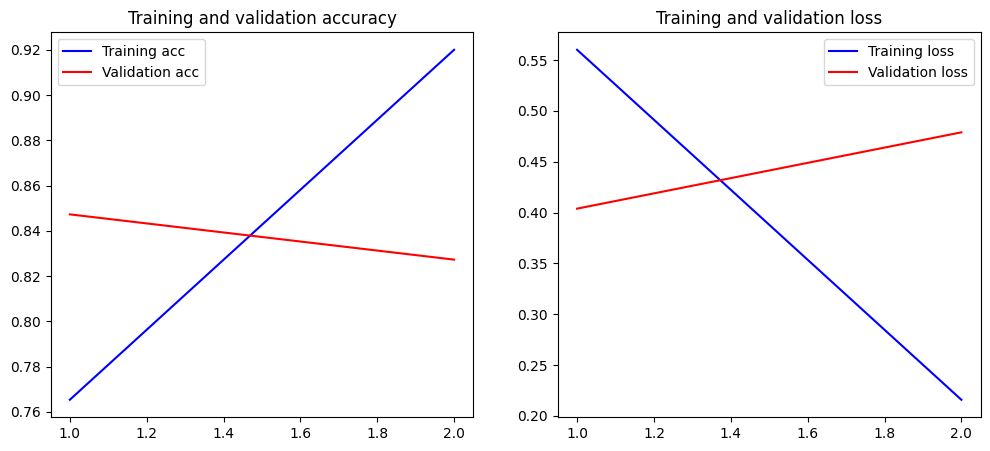

In [19]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [20]:
model.save('drive/MyDrive/DSC20/modelrnn.h5')
print("Model has created!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


#Data Testing

In [24]:
input_text = """
Rasa syukur, anjing.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('drive/MyDrive/DSC20/modelrnn.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 155ms/step
Text:   rasa syukur  anjing  
Sentiment:  negative
